Bibliotecas Importadas

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler, MultiLabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, r2_score
import warnings
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.svm import SVR
import xgboost as xgb 

#Apagando warning pq tava chovendo warning 
warnings.filterwarnings('ignore')


Lendo o dataset e encontrando valores ausentes

In [2]:
df = pd.read_csv(r"Movie_Data_File.csv")

print(df.info())

missing_values = df.isnull().sum()
print('Missing values in each column:')
print(missing_values[missing_values > 0])

df = df.drop(columns=["Release_year"]) # Está toda com NaN
df = df.drop(columns=["Owner_rating"]) # 90% NaN


missing_data = df[df.isnull().any(axis=1)]

df_atualizado = df.dropna()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10002 entries, 0 to 10001
Data columns (total 29 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Film_title         10002 non-null  object 
 1   Release_year       0 non-null      float64
 2   Director           9992 non-null   object 
 3   Cast               9945 non-null   object 
 4   Average_rating     9421 non-null   float64
 5   Owner_rating       967 non-null    float64
 6   Genres             9978 non-null   object 
 7   Runtime            9992 non-null   float64
 8   Countries          9884 non-null   object 
 9   Original_language  9999 non-null   object 
 10  Spoken_languages   9999 non-null   object 
 11  Description        10000 non-null  object 
 12  Studios            9695 non-null   object 
 13  Watches            10002 non-null  int64  
 14  List_appearances   10002 non-null  int64  
 15  Likes              10002 non-null  int64  
 16  Fans               100

Adicionando novas features

In [3]:
df_atualizado['Cast_size'] = df_atualizado['Cast'].apply(lambda x: len(eval(x)))  # Tamanho do elenco
df_atualizado['Language_count'] = df_atualizado['Spoken_languages'].apply(lambda x: len(eval(x)))  # Qtd idioma

#Tentei uma forma de transformar essas duas colunas 
#em algo numérico pois não estamos usando algo para interpretar grandes vetores de textos

df_atualizado['Director_freq'] = df_atualizado['Director'].map(df_atualizado['Director'].value_counts())
#Coluna que mostra quantos filmes o diretor fez



Gerando a correlação para escolher features

In [4]:
#preparar X mantendo como dataframe
X = df_atualizado[['Runtime', 'Cast_size', 'Language_count', 'Director_freq', 'Watches', 'List_appearances', 'Likes', 'Fans']]

#escalando X 
scaler_X = StandardScaler()
X_scaled = scaler_X.fit_transform(X)
X = pd.DataFrame(X_scaled, columns=X.columns)  #essa linha mantem ele como dataframe pra manter a estrutura

#preparando o y agora
y = df_atualizado['Average_rating']

#escalando y
scaler_y = StandardScaler()
y_scaled = scaler_y.fit_transform(y.values.reshape(-1, 1)).ravel()
y = y_scaled

In [5]:
#fazendo análise de correlação com features > 0.1
corr_matrix = X.corrwith(pd.Series(y)).sort_values(ascending=False)  #preciso converter y para series pq virou np
corr_matrix = corr_matrix[np.abs(corr_matrix) > 0.1]
selected_features = corr_matrix.index.tolist()
X = X[selected_features]

print("\nTop Features por Correlação > 0.1")
display(pd.DataFrame(corr_matrix).head(10))


Top Features por Correlação > 0.1


,0
List_appearances,0.375725
Likes,0.293180
Fans,0.253110
Watches,0.251753
Runtime,0.197566
Director_freq,0.142039
Language_count,0.106834


Aplicação de modelos

,Modelo,Erro Médio Absoluto (diferença média entre nota real e prevista),"Qualidade da Previsão (0 a 1, quanto mais perto de 1 melhor)"
0,Random Forest,0.197,0.780
5,XGBoost,0.201,0.774
4,Gradient Boosting,0.233,0.690
6,SVR,0.288,0.503
3,KNN Regressor,0.333,0.356
2,Ridge Regression,0.375,0.232
1,Linear Regression,0.375,0.232


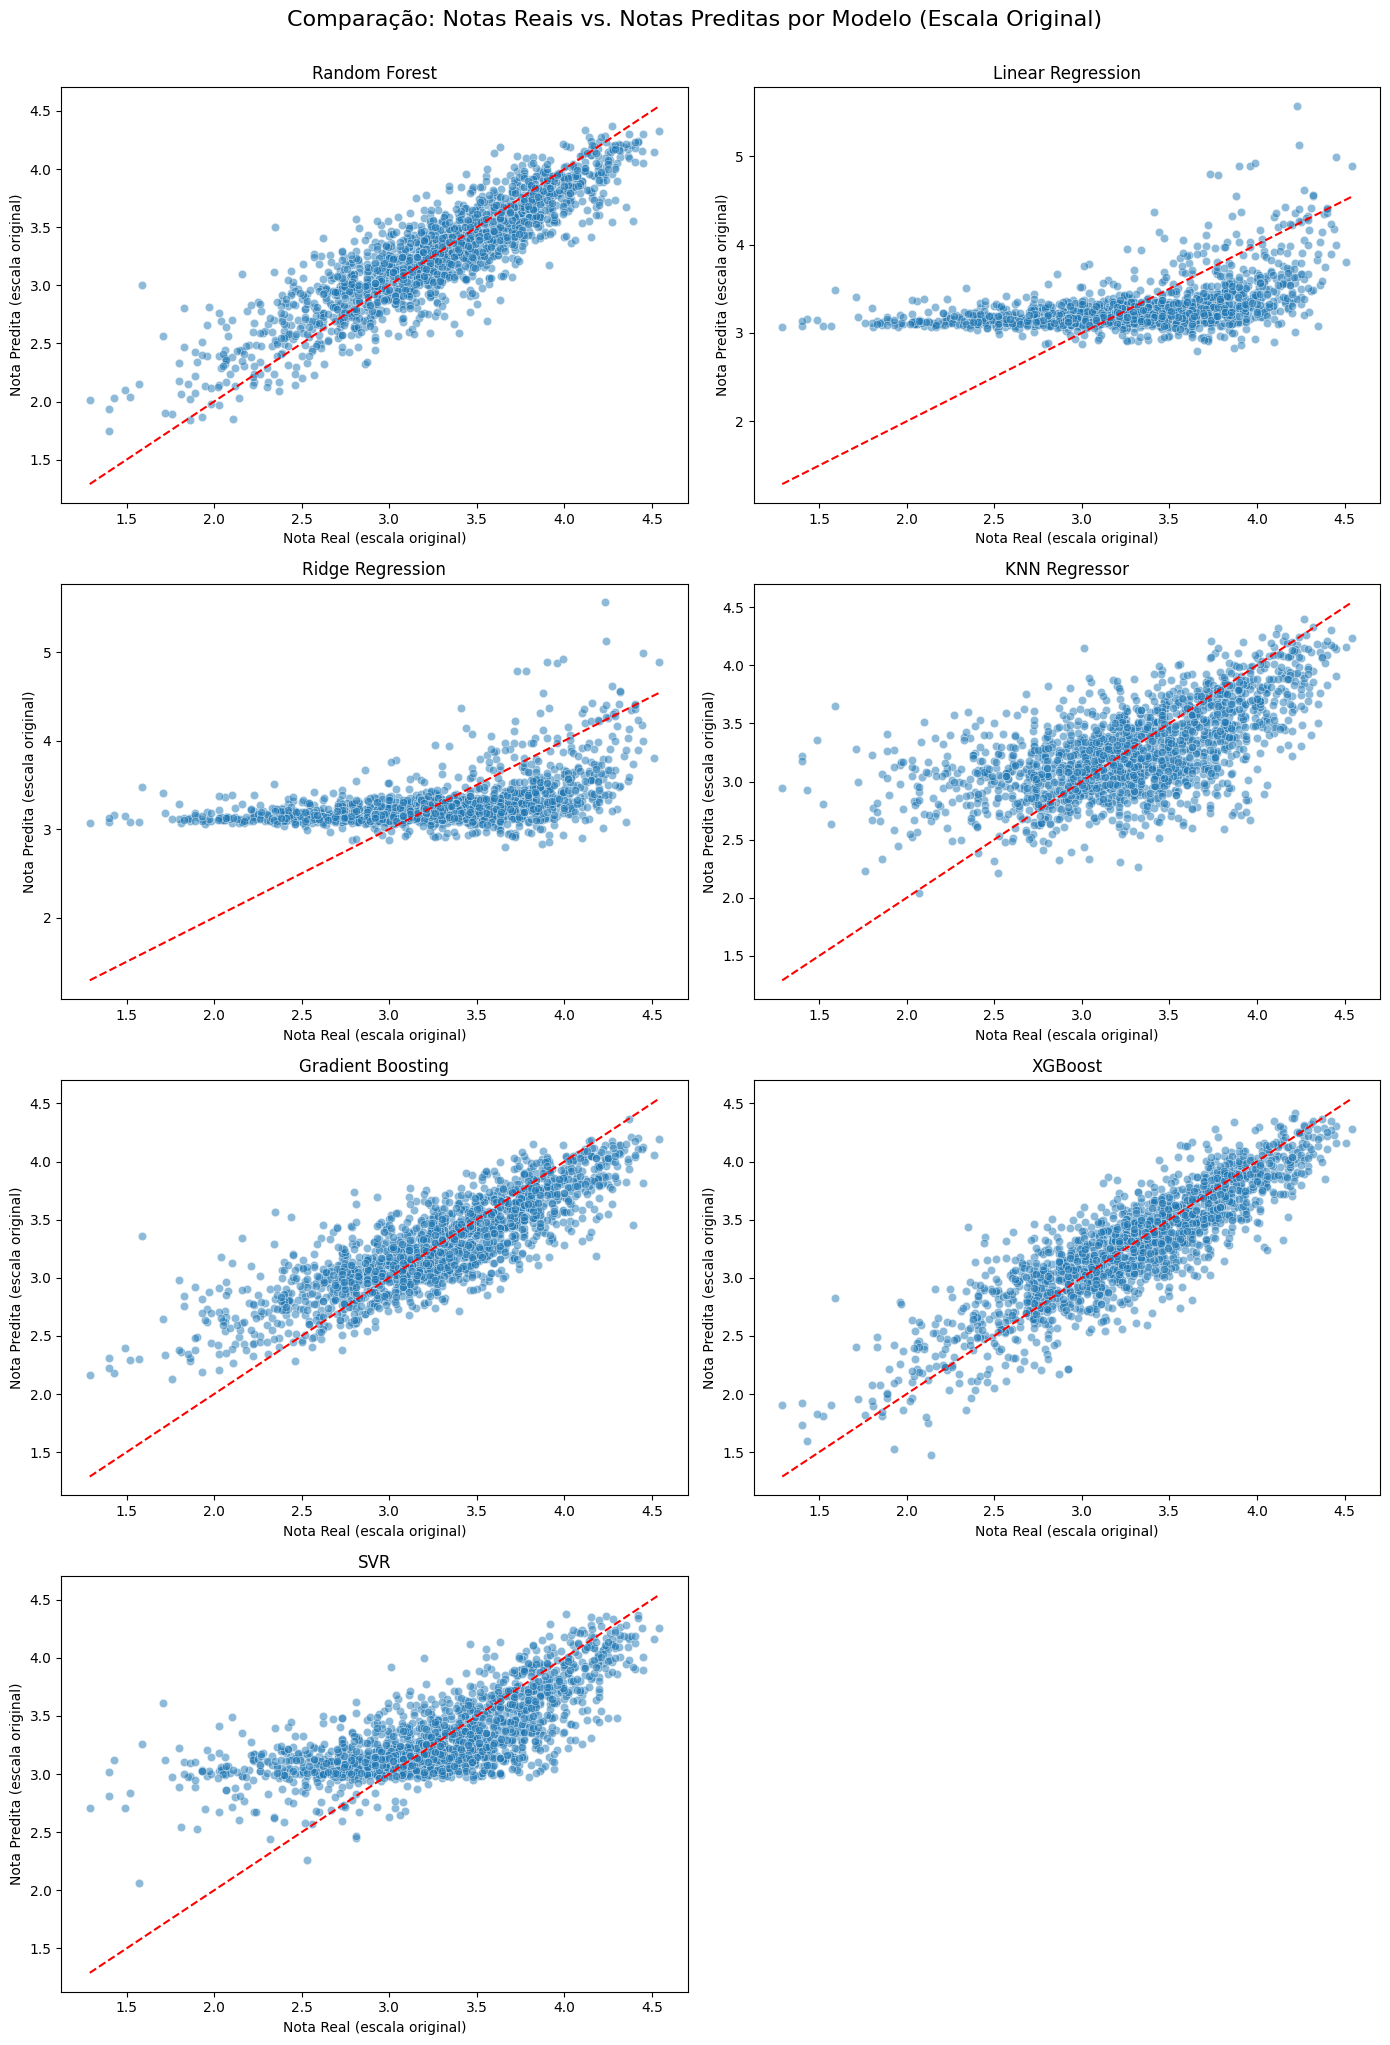

In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import GradientBoostingRegressor
import xgboost as xgb
from sklearn.svm import SVR
from sklearn.metrics import mean_absolute_error, r2_score
from sklearn.preprocessing import StandardScaler

#particionamento dos dados
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

#modelos usados
modelos = {
    "Random Forest": RandomForestRegressor(n_estimators=100, random_state=42),
    "Linear Regression": LinearRegression(),
    "Ridge Regression": Ridge(alpha=1.0),
    "KNN Regressor": KNeighborsRegressor(n_neighbors=5),
    "Gradient Boosting": GradientBoostingRegressor(n_estimators=100, random_state=42),
    "XGBoost": xgb.XGBRegressor(n_estimators=100, random_state=42),
    "SVR": SVR()
}

resultados = []

for nome, modelo in modelos.items():
    modelo.fit(X_train, y_train)
    y_pred = modelo.predict(X_test)
    
    #revertendo a normalização para calcular metricas de avaliacao
    y_test_original = scaler_y.inverse_transform(y_test.reshape(-1, 1)).ravel()
    y_pred_original = scaler_y.inverse_transform(y_pred.reshape(-1, 1)).ravel()
    
    mae = mean_absolute_error(y_test_original, y_pred_original)
    r2 = r2_score(y_test_original, y_pred_original)

    resultados.append({
        "Modelo": nome,
        "Erro Médio Absoluto (diferença média entre nota real e prevista)": round(mae, 3),
        "Qualidade da Previsão (0 a 1, quanto mais perto de 1 melhor)": round(r2, 3)
    })

#mostrando resultados como dataframe
resultados_df = pd.DataFrame(resultados).sort_values(
    by="Qualidade da Previsão (0 a 1, quanto mais perto de 1 melhor)", 
    ascending=False
)
display(resultados_df)

#construindo gráficos
fig, axes = plt.subplots(nrows=4, ncols=2, figsize=(14, 20))
axes = axes.flatten()

for i, (nome, modelo) in enumerate(modelos.items()):
    y_pred = modelo.predict(X_test)
    
    #revertendo normalizacao para os graficos
    y_test_original = scaler_y.inverse_transform(y_test.reshape(-1, 1)).ravel()
    y_pred_original = scaler_y.inverse_transform(y_pred.reshape(-1, 1)).ravel()
    
    ax = axes[i]
    sns.scatterplot(x=y_test_original, y=y_pred_original, alpha=0.5, ax=ax)
    ax.plot([y_test_original.min(), y_test_original.max()], 
            [y_test_original.min(), y_test_original.max()], '--r')
    ax.set_title(nome)
    ax.set_xlabel("Nota Real (escala original)")
    ax.set_ylabel("Nota Predita (escala original)")

#ocultando subplots alem do necessario
for j in range(i+1, len(axes)):
    fig.delaxes(axes[j])

#ajustando layout dos graficos
plt.tight_layout()
plt.suptitle("Comparação: Notas Reais vs. Notas Preditas por Modelo (Escala Original)", 
             fontsize=16, y=1.02)
plt.show()